# Goal
Create a set of GSW tiles that are in the same projection and grid as VIIRS 375 so that it can be processed without any reprojection or resampling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("/home/nick/C2S-Python-API/")
import rasterio
import matplotlib.pyplot as plt
import gcsfs
from c2s.external.stac.chip_creator import JRCProcessor, ChipCreator
import affine
import numpy as np
import time
from osgeo.gdal import GDT_Float32

In [3]:
gsw_location_src = "gs://jrc_globalsurfacewater/2019/occurrence-downsample-uint32"
gsw_location_dst = "gs://jrc_globalsurfacewater/2019/occurrence-viirs-uint32"

In [4]:
dst_crs = 'PROJCS["MODIS Sinusoidal",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Sinusoidal"],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["central_meridian",0.0],PARAMETER["semi_major",6371007.181],PARAMETER["semi_minor",6371007.181],UNIT["m",1.0]]'
dst_res = 347.48453739

In [5]:
crs_limit_west = -20015109.353664
crs_limit_north = 10007554.676832

In [6]:
# pick a reasonable size for each new GSW file
gsw_dims = 4800  # pixels

In [7]:
dst_dir = "/home/nick/C2S-Python-API/notebooks/gsw_viirs375"

In [8]:
# process them all
dst_dir = "/home/nick/C2S-Python-API/notebooks/gsw_viirs375"
os.makedirs(dst_dir, exist_ok=True)

# instantiate the processor once
# this was having some weird issues when using coarse... try with fine-res?
gsw_proc = ChipCreator(sensor="jrc")

gsw_dims = 4800
crs_limit_west = -20015109.353664
crs_limit_north = 10007554.676832
profile_template = {
    "driver": "GTiff",
    "width": gsw_dims,
    "height": gsw_dims,
    "crs": dst_crs,
    "count": 1,
    "dtype": "uint32",
    "nodata": 255,
    "compress": "lzw",
    "blockxsize": 256,
    "blockysize": 256,
    "tiled": True,
    "interleave": "pixel",
}

for col in range(24):
    for row in range(12):
        print(f"{row=} {col=}")
        # make transform for this row
        transform = affine.Affine(
            dst_res, 
            0, 
            crs_limit_west + gsw_dims * dst_res * col,
            0, 
            -1 * dst_res, 
            crs_limit_north - gsw_dims * dst_res * row
        )
        # update the transform
        dst_profile = profile_template.copy()
        dst_profile["transform"] = transform

        # prepare the dummy reference file
        dummy_arr = np.ones((1, gsw_dims, gsw_dims), dtype="float32")
        dummy_path = "./tmp.tif"
        with rasterio.open(dummy_path, "w", **dst_profile) as dst:
            dst.write(dummy_arr)

        # then use that dummy to make a reference GSW file
        gsw_profile = dst_profile.copy()
        gsw_profile["dtype"] = "float32"
        gsw_profile["nodata"] = 255 # not sure this is the best way to handle
        try:
            # gsw_proc.process(dummy_path, f"./FLOAT_TEST_col{col:02}_row{row:02}.tif", gsw_profile, resampling="average", vrt_options={"eWorkingDataType": GDT_Float32})
            gsw_proc.chipping(
                dummy_path, 
                f"{dst_dir}/col{col:02}_row{row:02}.tif",
                use_coarse_int32=True,
                resampling_method="average", 
                reader_params={"vrt_options": {"eWorkingDataType": GDT_Float32}}
            )
        except Exception as e:
            # if it fails, just write a whole bunch of nodata instead
            with rasterio.open(f"{dst_dir}/col{col:02}_row{row:02}.tif", "w", **gsw_profile) as dst:
                dst.write(np.ones((1, gsw_dims, gsw_dims), dtype=gsw_profile["dtype"]) * gsw_profile["nodata"])
        os.remove("./tmp.tif")

row=0 col=0
row=1 col=0
2023-05-04 17:58:19,633 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=0
2023-05-04 17:58:20,309 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=3 col=0
2023-05-04 17:58:20,965 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=4 col=0


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=0


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=0


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=0


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=0
2023-05-04 17:58:44,191 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=9 col=0
2023-05-04 17:58:44,811 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=10 col=0
2023-05-04 17:58:45,418 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=0
row=0 col=1
row=1 col=1
2023-05-04 17:58:47,043 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=1
2023-05-04 17:58:47,652 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=3 col=1


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=1


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=1


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=1


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=1


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=1


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=1
2023-05-04 17:59:23,591 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=10 col=1
2023-05-04 17:59:24,265 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=1
row=0 col=2
row=1 col=2
2023-05-04 17:59:25,901 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=2
2023-05-04 17:59:26,525 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=3 col=2


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=2


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=2


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=2


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=2


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=2


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=2
2023-05-04 18:00:13,171 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=10 col=2
2023-05-04 18:00:13,998 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=2
row=0 col=3
row=1 col=3
2023-05-04 18:00:15,688 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=3


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=3


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=3


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=3


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=3


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=3


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=3


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=3


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=3
2023-05-04 18:01:07,938 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=3
row=0 col=4
row=1 col=4
2023-05-04 18:01:09,575 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=4


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=4


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=4


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=4


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=4


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=4


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=4


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=4


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=4
2023-05-04 18:02:04,453 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=4
row=0 col=5
row=1 col=5
2023-05-04 18:02:06,031 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=5


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=5


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=5


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=5


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=5


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=5


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=5


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=5


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=5
2023-05-04 18:03:11,178 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=5
row=0 col=6
row=1 col=6


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=6


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=6


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=6


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=6


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=6


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=6


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=6


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=6


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=6
2023-05-04 18:04:34,390 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=6
row=0 col=7
row=1 col=7


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=7


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=7


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=7


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=7


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=7


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=7


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=7


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=7


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=7
2023-05-04 18:06:13,590 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=7
row=0 col=8
row=1 col=8


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=8


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=8


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=8


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=8


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=8


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=8


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=8


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=8


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=8
2023-05-04 18:08:00,301 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=8
row=0 col=9
row=1 col=9


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=9


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=9


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=9


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=9


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=9


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=9


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=9


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=9


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=9
2023-05-04 18:09:36,603 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=9
row=0 col=10
row=1 col=10


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=10


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=10


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=10


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=10


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=10


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=10


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=10


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=10


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=10
2023-05-04 18:10:53,137 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=10
row=0 col=11
row=1 col=11


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=11


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=11


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=11


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=11


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=11


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=11


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=11


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=11


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=11
2023-05-04 18:12:03,375 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=11
row=0 col=12
row=1 col=12


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=12


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=12


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=12


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=12


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=12


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=12


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=12


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=12


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=12
2023-05-04 18:13:32,389 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=12
row=0 col=13
row=1 col=13


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=13


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=13


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=13


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=13


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=13


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=13


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=13


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=13


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=13
2023-05-04 18:15:07,517 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=13
row=0 col=14
row=1 col=14


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=14


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=14


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=14


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=14


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=14


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=14


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=14


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=14


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=14
2023-05-04 18:16:40,342 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=14
row=0 col=15
row=1 col=15


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=15


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=15


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=15


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=15


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=15


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=15


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=15


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=15


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=15
2023-05-04 18:18:01,704 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=15
row=0 col=16
row=1 col=16


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=16


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=16


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=16


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=16


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=16


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=16


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=16


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=16


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=16
2023-05-04 18:19:25,281 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=16
row=0 col=17
row=1 col=17


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=2 col=17


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=17


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=17


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=17


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=17


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=17


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=17


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=17


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=17
2023-05-04 18:20:45,691 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.
row=11 col=17
row=0 col=18
row=1 col=18
2023-05-04 18:20:47,334 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=18


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=18


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=18


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=18


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=18


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=18


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=18


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=18


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=18
2023-05-04 18:22:05,360 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=18
row=0 col=19
row=1 col=19
2023-05-04 18:22:06,933 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=19


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=19


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=19


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=19


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=19


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=19


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=19


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=19


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=19
2023-05-04 18:23:25,065 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=19
row=0 col=20
row=1 col=20
2023-05-04 18:23:26,686 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=20


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=3 col=20


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=20


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=20


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=20


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=20


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=20


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=20


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=10 col=20
2023-05-04 18:24:33,715 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=20
row=0 col=21
row=1 col=21
2023-05-04 18:24:35,332 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=21
2023-05-04 18:24:35,941 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=3 col=21


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=21


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=21


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=21


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=21


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=21


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=21
2023-05-04 18:25:27,828 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=10 col=21
2023-05-04 18:25:28,447 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=21
row=0 col=22
row=1 col=22
2023-05-04 18:25:30,061 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=22
2023-05-04 18:25:30,670 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=3 col=22


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=4 col=22


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=22


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=22


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=22


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=22


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=9 col=22
2023-05-04 18:26:09,620 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=10 col=22
2023-05-04 18:26:10,232 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=22
row=0 col=23
row=1 col=23
2023-05-04 18:26:11,846 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=2 col=23
2023-05-04 18:26:12,454 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=3 col=23
2023-05-04 18:26:13,056 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=4 col=23


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=5 col=23


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=6 col=23


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=7 col=23


/usr/local/lib/python3.8/site-packages/rio_tiler/io/cogeo.py:139: NoOverviewWarning: The dataset has no Overviews. rio-tiler performances might be impacted.
  warnings.warn(


row=8 col=23
2023-05-04 18:26:36,984 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=9 col=23
2023-05-04 18:26:37,583 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=10 col=23
2023-05-04 18:26:38,189 c2s.external.stac.utils utils.py:243 ERROR: No intersections found, either the swath you are looking for is way out there and you don't actually need it or the intersection code of the additional data (e.g. GSW/DEM/...) is wrongly implemented.


/usr/local/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


row=11 col=23


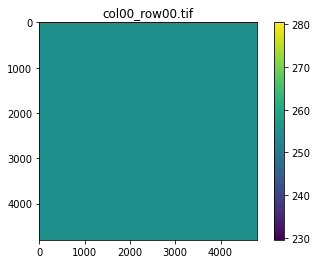

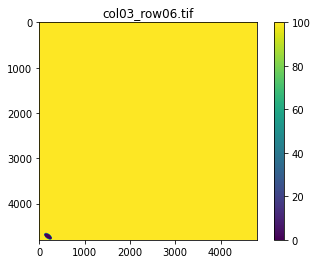

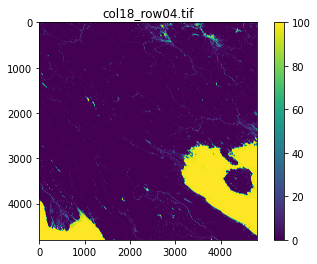

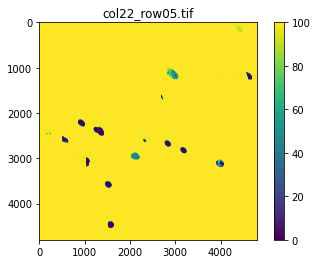

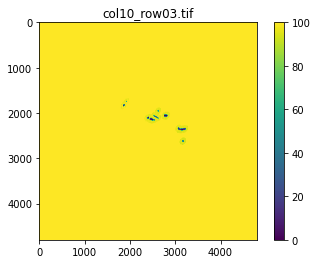

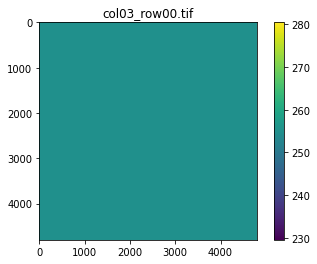

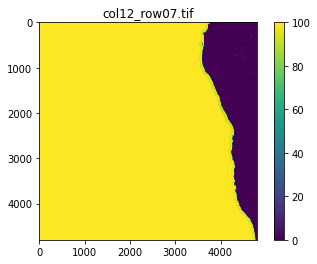

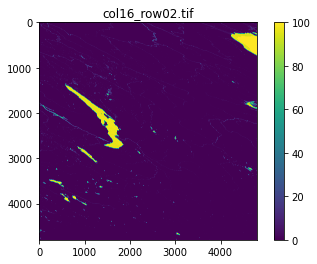

KeyboardInterrupt: 

In [8]:
# Visulize files to make sure they are correct
for path in [os.path.join(dst_dir, f) for f in os.listdir(dst_dir)]:
    with rasterio.open(path, "r") as src:
        arr = src.read(1)
    plt.imshow(arr)
    plt.title(os.path.basename(path))
    plt.colorbar()
    plt.show()

## Cleaning up GSW files

<b>Files that need cleaning</b>
- ~~col00row05~~
- ~~col00row06~~
- ~~col00row07~~
- ~~col02row04~~
- ~~col01row04~~
- ~~col01row06~~
- ~~col01row08~~
- ~~col01row07~~
- ~~col02row06~~
- ~~col02row07~~
- ~~col03row06~~
- ~~col03row07~~
- ~~col04row04~~
- ~~col04row07~~
- ~~col05row04~~
- ~~col05row05~~
- ~~col05row09~~
- ~~col22_row05~~
- ~~col22_row06~~
- ~~col22_row07~~

### col00row05

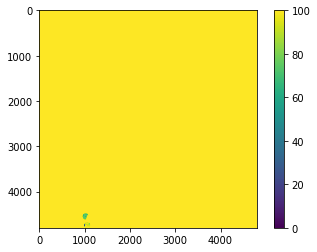

In [10]:
with rasterio.open(os.path.join(dst_dir, "col00_row05.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

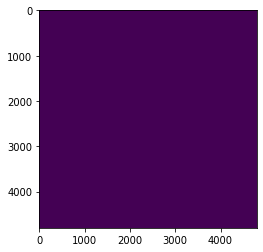

In [11]:
# replace with all nodata; islands here are too small to care about
dst_arr = np.ones_like(arr) * 100
plt.imshow(dst_arr)
with rasterio.open(os.path.join(dst_dir, "col00_row05_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col00row06

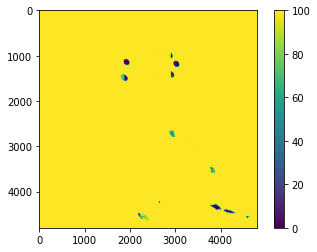

In [12]:
with rasterio.open(os.path.join(dst_dir, "col00_row06.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

In [14]:
dst_arr = arr * 1  # copy of arr
# replace everything in the top half with nodata
dst_arr[:4000, :] = 100

In [15]:
# replace any values that shouldn't exist out here
dst_arr = np.where((dst_arr > 3) & (dst_arr < 100), 100, dst_arr)

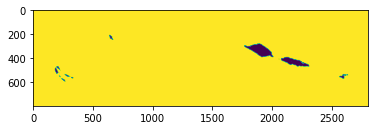

In [16]:
# very bottom part has some actual land but we need to get rid of the rest
plt.imshow(dst_arr[4000:, 2000:])

In [17]:
dst_arr[4400:4700, 2100:2250] = 100
dst_arr[4560:4700, 2100:2300] = 100

In [18]:
with rasterio.open(os.path.join(dst_dir, "col00_row06_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col00row07

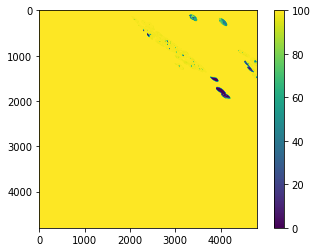

In [19]:
with rasterio.open(os.path.join(dst_dir, "col00_row07.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [20]:
dst_arr[:500, 3000:] = 100
dst_arr[1350:2000, 3500:4300] = 100
dst_arr[1000+175:1000+195, 4500:4602] = 100
dst_arr[1200:1700, 4450:-60] = 100
dst_arr[1000:1250, 4450:4600] = 100

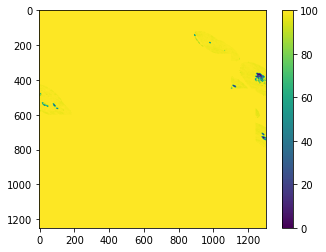

In [21]:
# issues are at the very top and bottom and along the right side. left side is good
plt.imshow(dst_arr[750:2000, 3500:])
plt.colorbar()

In [22]:
with rasterio.open(os.path.join(dst_dir, "col00_row07_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col02row04

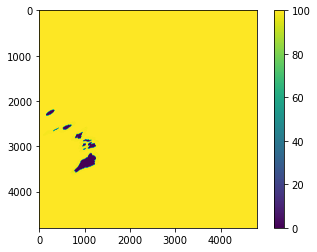

In [23]:
with rasterio.open(os.path.join(dst_dir, "col02_row04.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [24]:
dst_arr[:2350, :2000] = 100

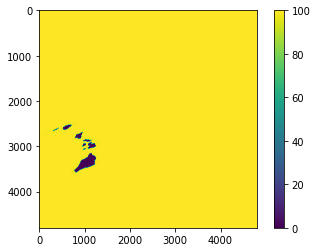

In [25]:
plt.imshow(dst_arr)
plt.colorbar()
with rasterio.open(os.path.join(dst_dir, "col02_row04_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col01row04

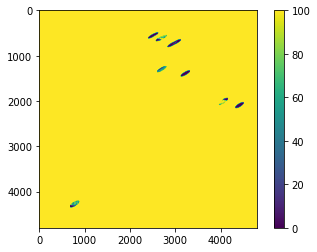

In [26]:
with rasterio.open(os.path.join(dst_dir, "col01_row04.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [27]:
dst_arr[:, :] = 100

In [28]:
with rasterio.open(os.path.join(dst_dir, "col01_row04_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col01row06

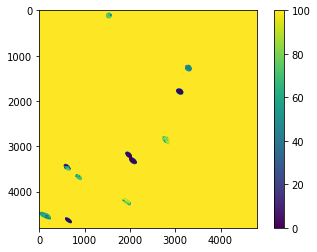

In [29]:
with rasterio.open(os.path.join(dst_dir, "col01_row06.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [30]:
dst_arr[:4000, :] = 100
dst_arr[:, 1000:] = 100

In [31]:
dst_arr = np.where((dst_arr > 3) & (dst_arr < 100), 100, dst_arr)
dst_arr[:, 500:] = 100

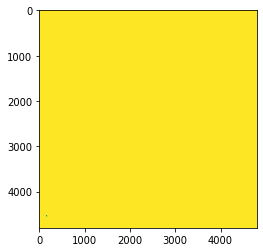

In [32]:
plt.imshow(dst_arr)

In [33]:
with rasterio.open(os.path.join(dst_dir, "col01_row06_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col01row08

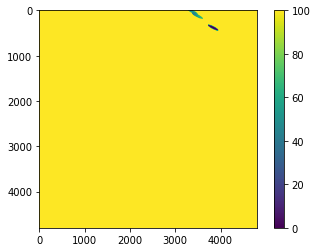

In [34]:
with rasterio.open(os.path.join(dst_dir, "col01_row08.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [35]:
dst_arr[:, :] = 100

In [36]:
with rasterio.open(os.path.join(dst_dir, "col01_row08_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col01row07

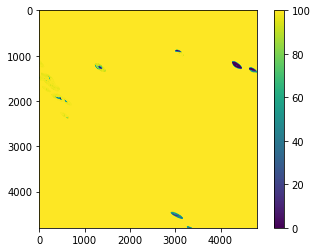

In [37]:
with rasterio.open(os.path.join(dst_dir, "col01_row07.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

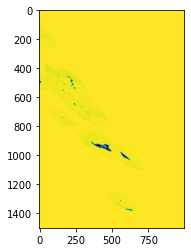

In [38]:
plt.imshow(dst_arr[1000:2500, :1000])

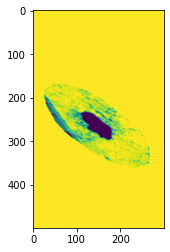

In [39]:
plt.imshow(dst_arr[1000:1500, 1200:1500])

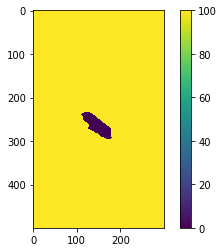

In [47]:
# need to do an erode/dilate on this
from scipy.ndimage import binary_erosion, binary_dilation

problem_area = (dst_arr[1000:1500, 1200:1500] < 5)
problem_area = binary_erosion(problem_area, iterations=2)
problem_area = binary_dilation(problem_area, iterations=2)
problem_area = (problem_area == 0) * 100
plt.imshow(problem_area, interpolation="none")
plt.colorbar()

In [48]:
dst_arr[1000:1500, 1200:1500] = problem_area

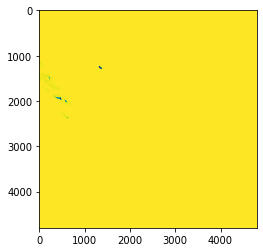

In [49]:
# everything else is junk
dst_arr[:, 2000:] = 100
plt.imshow(dst_arr)

In [50]:
with rasterio.open(os.path.join(dst_dir, "col01_row07_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col02row06

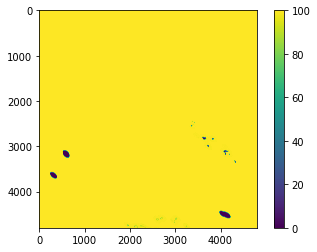

In [51]:
with rasterio.open(os.path.join(dst_dir, "col02_row06.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [52]:
# spots on left side are junk
dst_arr[:, :1000] = 100
# bottom right is junk, everywhere else is good
dst_arr[4000:, 3800:] = 100

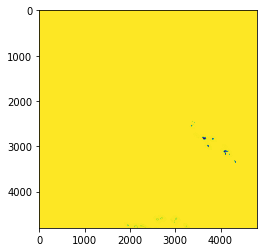

In [53]:
plt.imshow(dst_arr)

In [54]:
with rasterio.open(os.path.join(dst_dir, "col02_row06_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col02row07

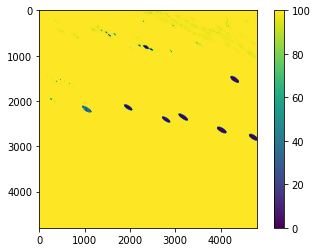

In [55]:
with rasterio.open(os.path.join(dst_dir, "col02_row07.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

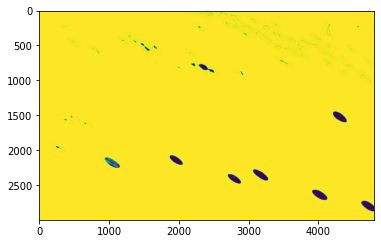

In [56]:
plt.imshow(dst_arr[:3000, :])

In [57]:
dst_arr[1200:3000, 1500:] = 100
dst_arr[2000:3000, 800:1200] = 100

In [58]:
with rasterio.open(os.path.join(dst_dir, "col02_row07_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col03row06

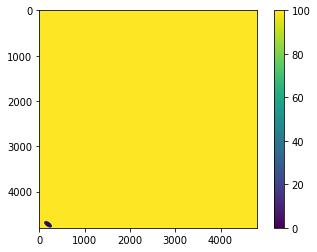

In [60]:
with rasterio.open(os.path.join(dst_dir, "col03_row06.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [61]:
dst_arr[:, :] = 100

In [62]:
with rasterio.open(os.path.join(dst_dir, "col03_row06_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col03row07

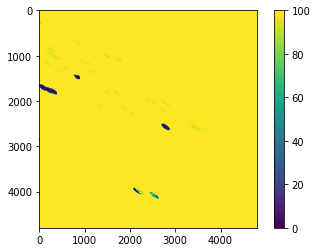

In [63]:
with rasterio.open(os.path.join(dst_dir, "col03_row07.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [64]:
dst_arr[1500:2000, :1000] = 100
dst_arr[1250:1750, 700:950] = 100
dst_arr[2400:3000, 2000:3000] = 100
dst_arr[3000:, :] = 100

In [65]:
with rasterio.open(os.path.join(dst_dir, "col03_row07_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col04row04

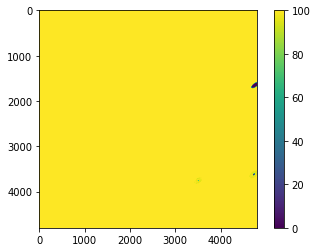

In [66]:
with rasterio.open(os.path.join(dst_dir, "col04_row04.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [67]:
dst_arr = np.where((dst_arr > 3) & (dst_arr < 100), 100, dst_arr)

In [68]:
dst_arr[1000:2000, :] = 100

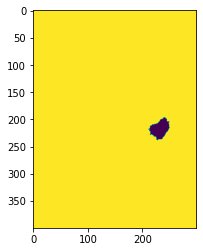

In [69]:
plt.imshow(dst_arr[3400:3800, 4500:])

In [70]:
with rasterio.open(os.path.join(dst_dir, "col04_row04_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col04row07

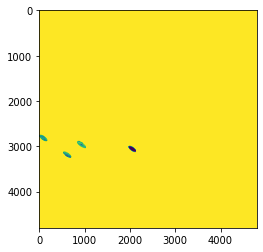

In [71]:
with rasterio.open(os.path.join(dst_dir, "col04_row07.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.show()

dst_arr = arr * 1

In [72]:
# leftmost and rightmost are junk
# middle two are complicated
dst_arr[2500:3000, :200] = 100
# second from left is small enough to not really matter
dst_arr[3000:3300, 200:800] = 100
dst_arr[2800:3300, 1900:2300] = 100

In [73]:
dst_arr = np.where((dst_arr > 1) & (dst_arr < 100), 100, dst_arr)

In [74]:
dst_arr[2850:2945, 800:1050] = 100

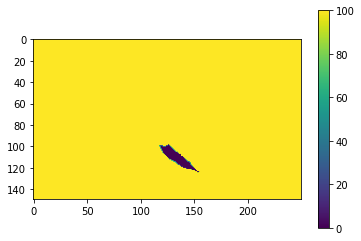

In [75]:
plt.imshow(dst_arr[2850:3000, 800:1050])
plt.colorbar()

In [76]:
with rasterio.open(os.path.join(dst_dir, "col04_row07_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col05row04

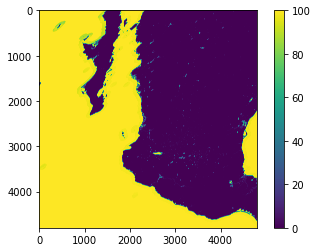

In [77]:
with rasterio.open(os.path.join(dst_dir, "col05_row04.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

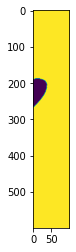

In [78]:
# just that one dumb chunk
plt.imshow(dst_arr[1400:2000, :100])

In [79]:
dst_arr[1400:2000, :100] = 100

In [80]:
with rasterio.open(os.path.join(dst_dir, "col05_row04_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col05row05

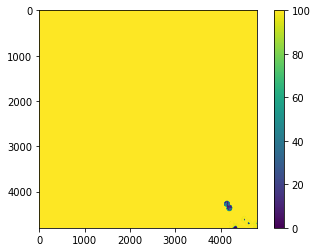

In [81]:
with rasterio.open(os.path.join(dst_dir, "col05_row05.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

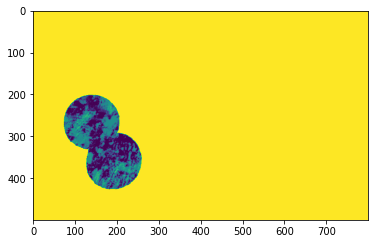

In [82]:
# just the top two spots are funny
plt.imshow(dst_arr[4000:4500, 4000:])

In [83]:
dst_arr[4000:4500, 4000:] = 100

In [84]:
with rasterio.open(os.path.join(dst_dir, "col05_row05_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col05row09

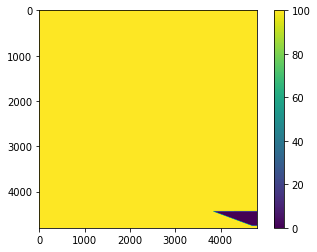

In [85]:
with rasterio.open(os.path.join(dst_dir, "col05_row09.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [86]:
dst_arr[:, :] = 100

In [87]:
with rasterio.open(os.path.join(dst_dir, "col05_row09_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col22_row05

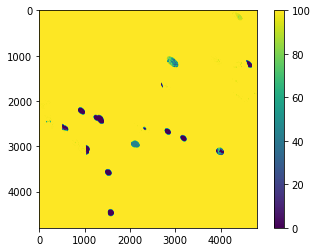

In [89]:
with rasterio.open(os.path.join(dst_dir, "col22_row05.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [116]:
# mostly little mistakes and a few atolls that we don't care about
dst_arr[2000:, 300:2000] = 100
dst_arr[2800:3300, 1800:2400] = 100
dst_arr[2500:3500, 2500:3500] = 100
dst_arr[2900:3300, 3800:4100] = 100
dst_arr[1000:1800, 2400:3100] = 100
dst_arr[1000:1500, 4500:] = 100

In [117]:
with rasterio.open(os.path.join(dst_dir, "col22_row05_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col22_row06

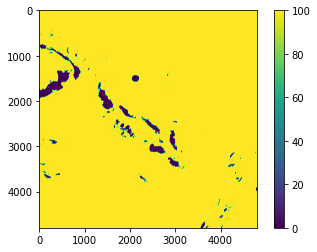

In [118]:
with rasterio.open(os.path.join(dst_dir, "col22_row06.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [146]:
# mostly good but there are a few funny spots
dst_arr[400:650, 200:400] = 100
dst_arr[1300:1700, 2000:2400] = 100
dst_arr[1350:1550, 2700:3000] = 100
dst_arr[3100:3300, 4100:4400] = 100
dst_arr[3500:4000, 4700:] = 100
dst_arr[3500:3850, 4410:4500] = 100
dst_arr[3740:3850, 4100:4500] = 100

In [147]:
with rasterio.open(os.path.join(dst_dir, "col22_row06_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

### col22_row07

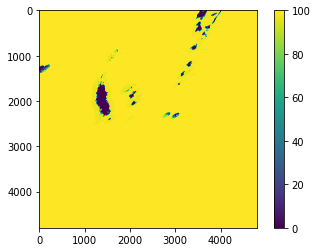

In [148]:
with rasterio.open(os.path.join(dst_dir, "col22_row07.tif"), "r") as src:
    profile = src.profile
    arr = src.read(1)
    
plt.imshow(arr)
plt.colorbar()
plt.show()

dst_arr = arr * 1

In [155]:
dst_arr[1000:2000, :500] = 100
dst_arr[700:1300, 1000:2000] = 100
dst_arr[2000:3000, 2500:3500] = 100

In [156]:
with rasterio.open(os.path.join(dst_dir, "col22_row07_fixed.tif"), "w", **profile) as dst:
    dst.write_band(1, dst_arr)

# Upload new GSW files to GCS

In [157]:
gcs_root = "gs://jrc_globalsurfacewater/2019/occurrence-viirs375"

fs = gcsfs.GCSFileSystem()

In [158]:
import shutil

root = "/home/nick/C2S-Python-API/notebooks/gsw_viirs375/"
backup_dir = "/home/nick/C2S-Python-API/notebooks/gsw_viirs375_backup/"
os.makedirs(backup_dir, exist_ok=True)

paths_local = [os.path.join(root, p) for p in os.listdir(root)]

# identify the files that were fixed up manually
for p in paths_local:
    if p.endswith("_fixed.tif"):
        # move the original somewhere safe, just leaving the original here
        shutil.move(p.replace("_fixed.tif", ".tif"), os.path.join(backup_dir, os.path.basename(p)))

In [159]:
paths_local = [os.path.join(root, p) for p in os.listdir(root)]

# iterate through and upload to gcs
for p in paths_local:
    if p.endswith("_fixed.tif"):
        # rename the ones ending with "_fixed.tif", then upload
        shutil.move(p, p.replace("_fixed.tif", ".tif"))
        fs.put(p.replace("_fixed.tif", ".tif"), os.path.join(gcs_root, os.path.basename(p.replace("_fixed.tif", ".tif"))))
    else:
        # just upload the others
        fs.put(p, os.path.join(gcs_root, os.path.basename(p)))